# Imports

In [92]:
from skimage import filters
from skimage import io, color
import numpy as np
from scipy.ndimage import convolve, maximum_filter
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') #avoid annoying imshow deprecated
import math
from typing import Literal
from tqdm import tqdm
import torch

import utils

# Load sample data

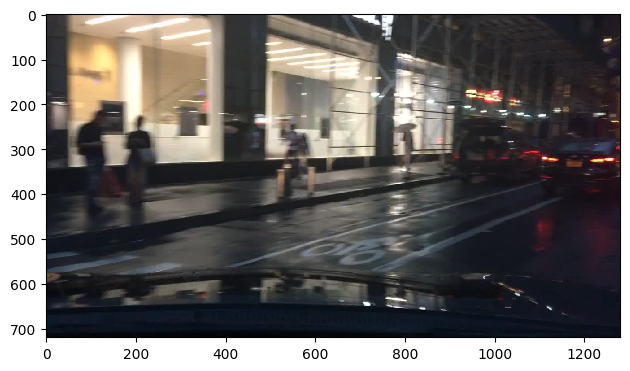

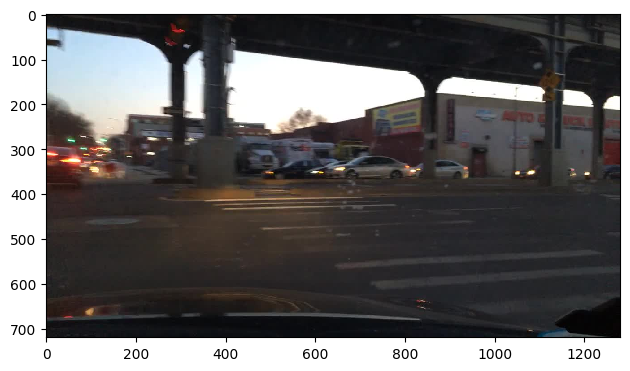

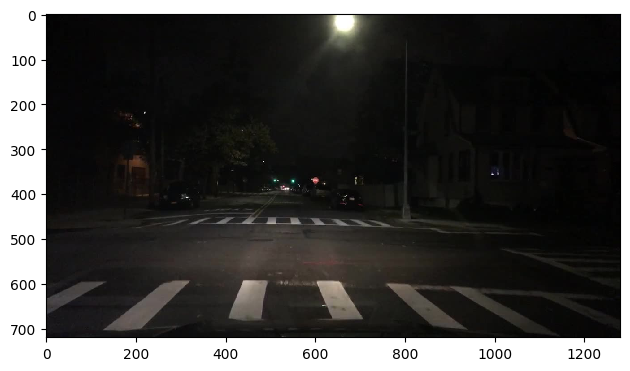

In [93]:
sample_images = utils.get_sample_images()
utils.plot_sample_images(sample_images[:3])

In [94]:
sample_img = sample_images[1]

# SLIC setup

Adjusted from hw7 to include time analysis

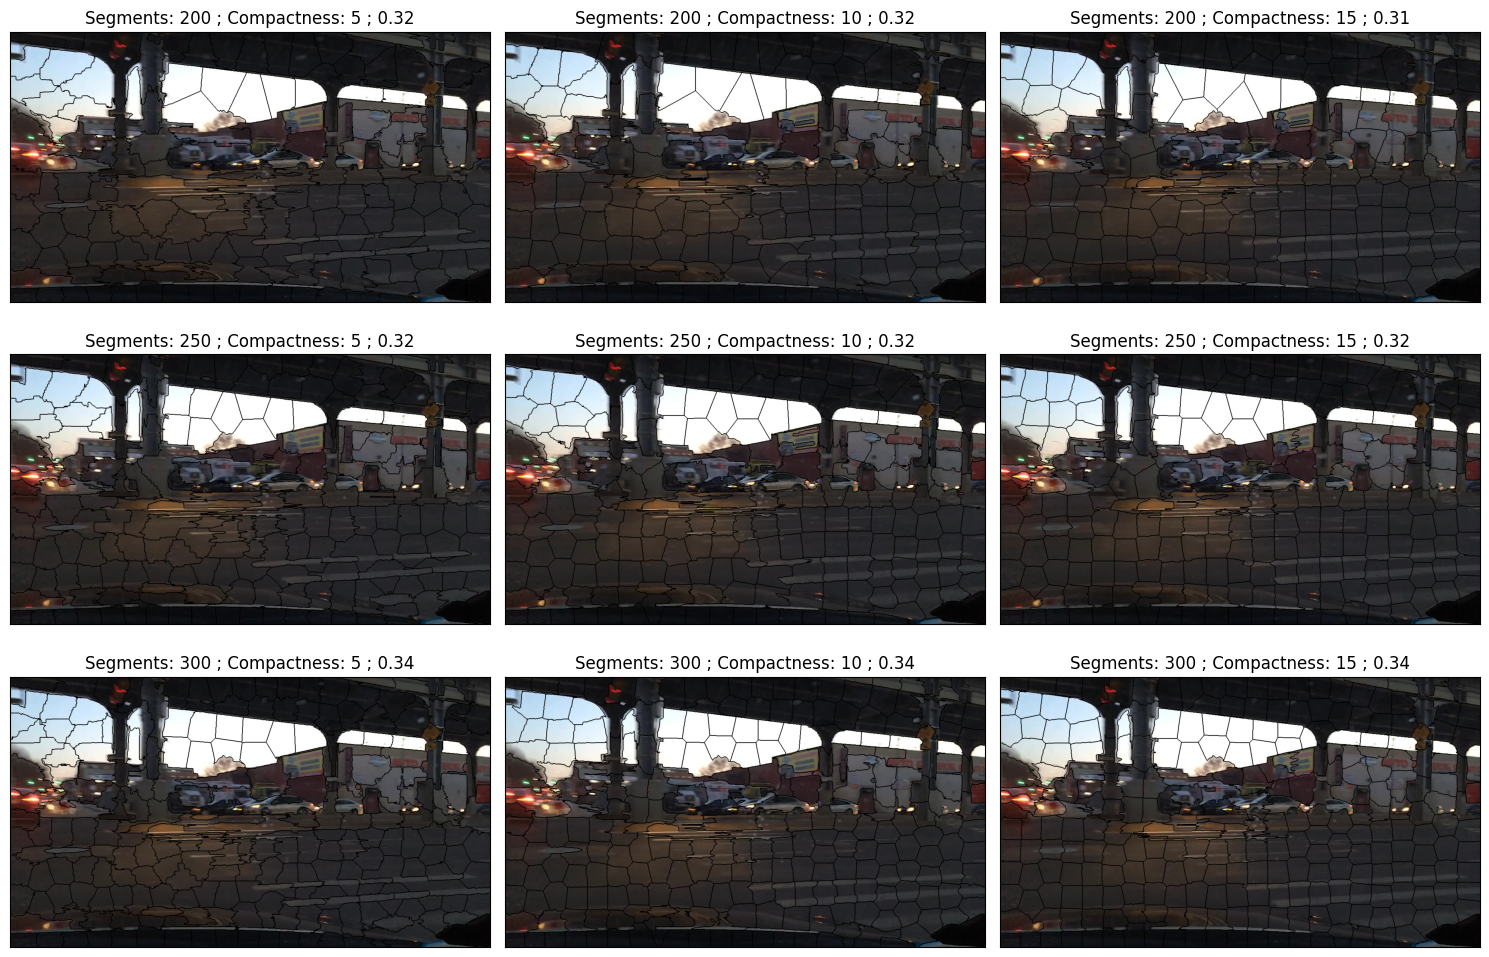

In [95]:
from skimage.segmentation import slic, mark_boundaries
import time

n_segments = np.arange(200, 301, 50)
compactness = np.arange(5, 16, 5)
n_segments, compactness

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
for i, n in enumerate(n_segments):
    for j, c in enumerate(compactness):
        time_s = time.time()
        ax = axes[i,j] ; ax.set_xticks([]); ax.set_yticks([])
        segments_slic = slic(sample_img, n_segments=n, compactness=c, start_label=1)
        ax.imshow(mark_boundaries(sample_img, segments_slic, color=(0,0,0)))
        ax.set_title(label=f'Segments: {n} ; Compactness: {c} ; {time.time() - time_s:.2f}')
plt.tight_layout()

# Discusion
 - There a couple noteworthy points in the image, one would be the top of the tree above the brick building, another being the small box in the top left.
 - It appears that all combinations of segments and compactness have a superpixel for these sections, but some are closer than others (segments 300, compactness 10 vs. segments 250 compactness 5)
 - All the options took roughly the same time, but to combine superpixels later a smaller number of segments will likely be quicker

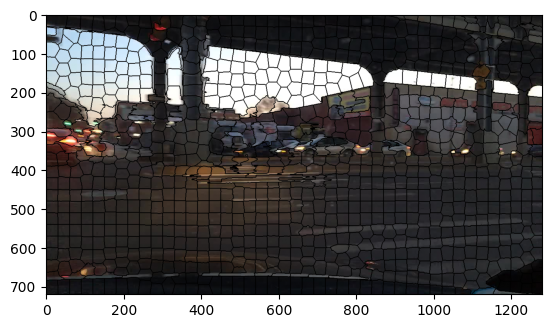

In [121]:
def plot_SLIC(img, n_segments, compactness):
    segments_slic = slic(img, n_segments=n_segments, compactness=compactness, start_label=1)
    plt.imshow(mark_boundaries(sample_img, segments_slic, color=(0,0,0)))
    return segments_slic

segments_slic = plot_SLIC(sample_img, 1000, 15)

In [122]:
segments_slic

array([[  1,   1,   1, ...,  40,  40,  40],
       [  1,   1,   1, ...,  40,  40,  40],
       [  1,   1,   1, ...,  40,  40,  40],
       ...,
       [931, 931, 931, ..., 939, 939, 939],
       [931, 931, 931, ..., 939, 939, 939],
       [931, 931, 931, ..., 939, 939, 939]], shape=(720, 1280))

In [123]:
np.unique(segments_slic)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [124]:
mask = (segments_slic == 1)
mask

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(720, 1280))

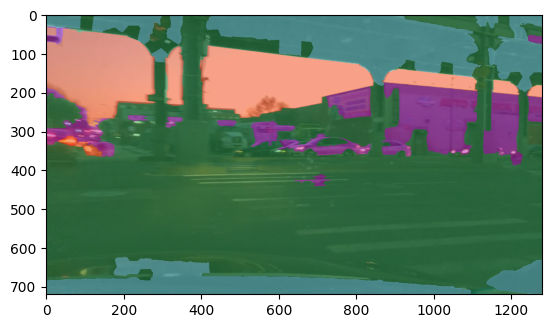

In [142]:
from sklearn.cluster import AgglomerativeClustering

def merge_superpixels(img, segments, distance_thresh=2.25, color_wt=1.0, pos_wt=0.25):
    # merge based on similarity based on [avg r,g,b of each segment, abg x, y of each segment]
    ROWS, COLS = img.shape[:2]
    features = {}

    for segment_id in np.unique(segments):
        mask = (segments == segment_id)

        #get avg x,y in mask
        avg_x, avg_y = np.column_stack(np.nonzero(mask)).mean(axis=0)
        avg_x /= ROWS
        avg_y /= COLS

        #get avg r,g,b within mask
        avg_rgb = img[mask].mean(axis=0) / 255.0

        features[segment_id] = np.hstack((avg_rgb * color_wt, avg_x * pos_wt, avg_y * pos_wt))

    seg_ids = sorted(features.keys())
    X = np.vstack([features[i] for i in seg_ids])

    model = AgglomerativeClustering(
        n_clusters=None, #let algorithm decide from distance_thresh
        distance_threshold=distance_thresh,
        # linkage='ward',
    )
    labels = model.fit_predict(X)

    seg_to_clust = {id: label for id, label in zip(seg_ids, labels)}
    merged = np.zeros_like(segments)
    for s_id, c_id in seg_to_clust.items(): merged[segments==s_id] = c_id

    return merged

def show_overlay(img, merged_map, alpha=0.5):
    unique_labels = np.unique(merged_map)
    colors = np.random.rand(len(unique_labels), 3)

    color_map = np.zeros((*merged_map.shape, 3))
    for idx, lab in enumerate(unique_labels):
        color_map[merged_map == lab] = colors[idx]

    overlay = (1 - alpha) * img/255.0 + alpha * color_map

    plt.imshow(overlay) ; plt.show()

merged = merge_superpixels(img=sample_img, segments=segments_slic)
show_overlay(sample_img, merged)

# Looks decent